In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
%matplotlib inline
import random
from sklearn import preprocessing
import scipy.sparse as sparse
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv('datasets/reviews_simpleInt.csv')

## Overview

This notebook walks you through a few baseline models Test RMSE calculations.

Baseline Models involve Simple Averaging: Total Train Populationa and a weighted combination of User vs. Item Avg.

Best Test RMSE through these Baseline Models was .817, achieved with an ItemAvg Weight of .4

## Creating a Sparse Matrix

In [29]:
print df.shape
df.head()

(982619, 3)


,itemID,userID,rating
0,0,7773,5
1,0,61894,4
2,0,53977,4
3,0,8128,5
4,0,50527,4


In [46]:
np.bincount(df['rating'].values)

array([     0,  23018,  34130,  96194, 254013, 575264])

In [30]:
users = len(set(df.userID))
items = len(set(df.itemID))

In [31]:
mtx = sparse.csr_matrix((df.rating, (df.userID, df.itemID)), shape=(users, items))

In [32]:
mtx.shape

(68223, 61934)

In [33]:
mtx.non

<68223x61934 sparse matrix of type '<type 'numpy.int64'>'
	with 982619 stored elements in Compressed Sparse Row format>

In [ ]:
mtx[i:]

In [ ]:
userSTD = []
itemSTD = []
nUsers = mtx.shape[0]
nUsers = mtx.shape[1]
for i in range(nUsers):
    mtxTrain[i,:].nonzero()[0]

In [40]:
mtx[:,5].nonzero()[0]

array([ 1453, 15475, 17395, 30311, 40593, 44810, 50670, 59616, 63899], dtype=int32)

## Train / Test Split

In [6]:
y = df.values[:,-1]
x = df.values[:,:-1]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [8]:
mtxTrain = sparse.csr_matrix((y_train, (x_train[:,1], x_train[:,0])), shape=(users, items))

In [9]:
mtxTest = sparse.csr_matrix((y_test, (x_test[:,1], x_test[:,0])), shape=(users, items))

In [10]:
yAvg_Train = mtxTrain.sum() /float(len(mtxTrain.nonzero()[0]))
yAvg_Train

4.3452592971022312

In [11]:
### Given Actual and Predict, Return RMSE
def RMSE (y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

## Simple Averaging - Always Predict Train Avg. 

In [12]:
## Given x_test, always predict Val
## Returns Predictions
def alwaysPredict(x_test, val):
    length = x_test.shape[0]
    return np.ones(length)*float(val)

In [31]:
nPredict = 10000
always_yAvg_predictions = alwaysPredict(x_test[:nPredict],yAvg_Train)
always_yAvg_RMSE = RMSE(y_test[:nPredict], always_yAvg_predictions)

In [32]:
print "Always Predict Y_Train_Avg Test RSME:     %0.2f" %always_yAvg_RMSE

Always Predict Y_Train_Avg Test RSME:     0.96


In [40]:
constants = [3,4,yAvg_Train,5]

In [41]:
nPredict = 10000
RMSE_List_Always = []

for i in range(len(constants)):
    alwaysPredictions = alwaysPredict(x_test[:nPredict],constants[i])
    RMSE_List_Always.append(RMSE(y_test[:nPredict], alwaysPredictions))

In [42]:
RMSE_List_Always

[1.656713614358257, 1.0237675517420934, 0.962702631072603, 1.162540321881353]

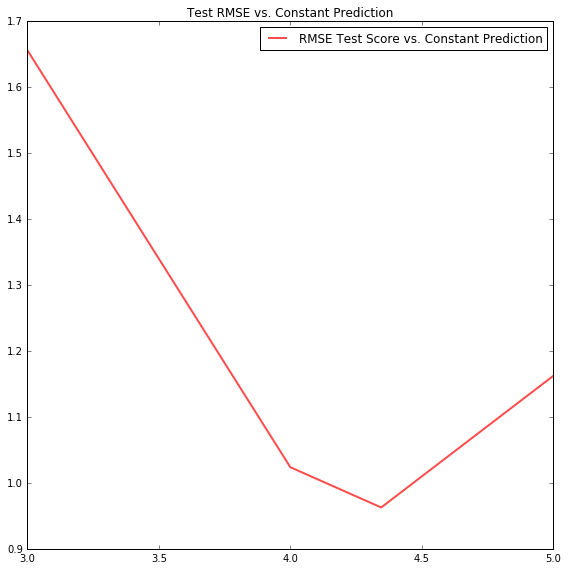

In [43]:

#plot R^2 Values
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 8))


# plot R^2 Test
ax1.plot(constants, 
            RMSE_List_Always, 
            color='red',
            linewidth=2.0,
            alpha=0.7,
            label="RMSE Test Score vs. Constant Prediction")
    
ax1.legend(loc='best')
ax1.set_title('Test RMSE vs. Constant Prediction')

plt.tight_layout()
plt.show()

## Simple Averaging - User Avg. Ratings and Item Avg. Ratings

In [18]:
## Given x_test, predict y_test based on mtxTrain (itemAvg and userAvg)
## Returns Predictions
def simpleAvg(x_test, wItem = .5):
    predict = np.zeros(len(x_test))
    nPredict =x_test.shape[0]
    wUser = float(1 - wItem)
    
    for i in range(nPredict):
        itemID = x_test[i,0]
        userID = x_test[i,1]
        itemNonZeros = len(mtxTrain[:,itemID].nonzero()[0])
        userNonZeros = len(mtxTrain[userID,:].nonzero()[0])
        
        if itemNonZeros == 0 and userNonZeros == 0:
            predict[i] = yAvg_Train
        elif itemNonZeros == 0:
            userSum= (mtxTrain[userID,:].sum())
            userAvg = userSum/float(userNonZeros)
            predict[i] = userAvg
        elif userNonZeros == 0:
            itemSum= (mtxTrain[:,itemID].sum())
            itemAvg = itemSum/float(itemNonZeros)
            predict[i] = itemAvg
        else:
            userSum= (mtxTrain[userID,:].sum())
            userAvg = userSum/float(userNonZeros)
            itemSum= (mtxTrain[:,itemID].sum())
            itemAvg = itemSum/float(itemNonZeros)
            
            predict[i] = wItem * itemAvg + wUser * userAvg 
    
    return predict

In [20]:
nPredict = 10000
simpleAvgPredictions = simpleAvg(x_test[:nPredict])
simpleAvgRMSE = RMSE(y_test[:nPredict], simpleAvgPredictions)


In [22]:
print "Obvi Algo Test RSME:     %0.2f" %simpleAvgRMSE

Obvi Algo Test RSME:     0.83


In [23]:
weights = np.array(range(0,11))*.1

In [26]:
nPredict = 2000
RMSE_List = []

for i in range(len(weights)):
    simpleAvgPredictions = simpleAvg(x_test[:nPredict],weights[i])
    RMSE_List.append(RMSE(y_test[:nPredict], simpleAvgPredictions))

In [27]:
RMSE_List

[0.8657735462768529,
 0.8436526416524239,
 0.8279432999936115,
 0.8190145408626105,
 0.8170886795124243,
 0.8222149257543337,
 0.83426329176222,
 0.8529404889753731,
 0.8778235001343067,
 0.9084024983152704,
 0.9441241880206691]

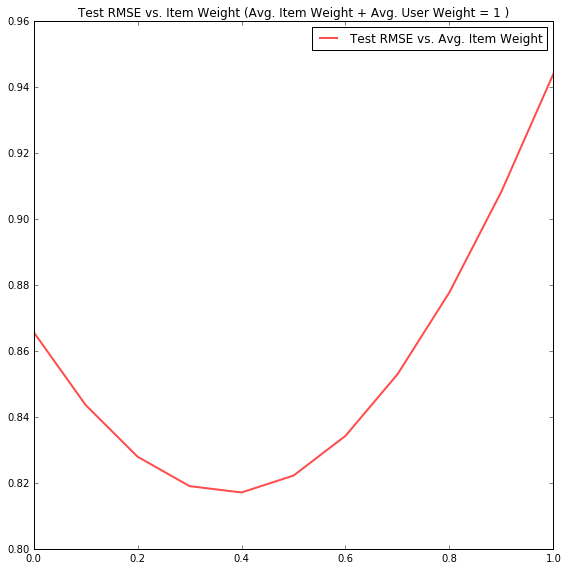

In [45]:

#plot R^2 Values
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 8))


# plot R^2 Test
ax1.plot(weights, 
            RMSE_List, 
            color='red',
            linewidth=2.0,
            alpha=0.7,
            label="Test RMSE vs. Avg. Item Weight")
    
ax1.legend(loc='best')
ax1.set_title('Test RMSE vs. Item Weight (Avg. Item Weight + Avg. User Weight = 1 )')

plt.tight_layout()
plt.show()